In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt  # Importing keras_tuner


In [3]:
# Charger les données
file_path = r'C:\Users\Elvis\Downloads\FH.csv'
df = pd.read_csv(file_path, sep=';')
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y %H:%M')

# Assurer que les colonnes Temperature et Humidity sont de type numérique
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
if df['Humidity'].dtype == 'object':
    df['Humidity'] = df['Humidity'].str.replace(',', '.').astype(float)

In [4]:
# Réinitialiser l'index du DataFrame
df = df.set_index('ds')

# Remplir les données manquantes par la méthode de remplissage en arrière
df['Temperature'].fillna(method='bfill', inplace=True)
df['Humidity'].fillna(method='bfill', inplace=True)

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)


In [5]:
# Convertir en DataFrame
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

# Création de séquences pour LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Définir la longueur des séquences
seq_length = 24

# Séparer les données en ensembles d'entraînement et de test
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

# Créer les séquences
X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)

# Diviser les données d'entraînement en ensembles d'entraînement et de validation
validation_split = 0.2
val_size = int(len(X_train) * validation_split)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

# Construction du modèle avec Keras Tuner pour optimiser les hyperparamètres
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), 
                   return_sequences=True, 
                   input_shape=(seq_length, 2)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(2))  # Deux sorties : température et humidité

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error')
    return model

# Configuration du tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Ajustez selon vos besoins
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)



Reloading Tuner from my_dir\helloworld\tuner0.json


In [6]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Recherche des meilleurs hyperparamètres
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Récupération des meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Le nombre optimal d'unités dans la première couche LSTM est {best_hps.get('units')}.
Le taux de dropout optimal est {best_hps.get('dropout')}.
Le taux d'apprentissage optimal pour l'optimiseur est {best_hps.get('learning_rate')}.
""")

# Construction du modèle avec les meilleurs hyperparamètres
model = tuner.hypermodel.build(best_hps)

# Entraînement du modèle
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

# Sauvegarde du modèle
model.save('best_model.h5')



Le nombre optimal d'unités dans la première couche LSTM est 64.
Le taux de dropout optimal est 0.2.
Le taux d'apprentissage optimal pour l'optimiseur est 0.008205809564721014.

Epoch 1/200


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.2029 - val_loss: 0.0758
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0666 - val_loss: 0.0621
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0522 - val_loss: 0.0542
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0469 - val_loss: 0.0435
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0378 - val_loss: 0.0374
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0410 - val_loss: 0.0378
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0334 - val_loss: 0.0356
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0317 - val_loss: 0.0362
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0334 - val_loss: 0.0357
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0337 - val_loss: 0.0370
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0328 - val_loss: 0.0366
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Temperature - MSE: 1.21594139530522, MAE: 0.6589183023101405
Humidity - MSE: 8.367419214036326, MAE: 2.3924936495329203


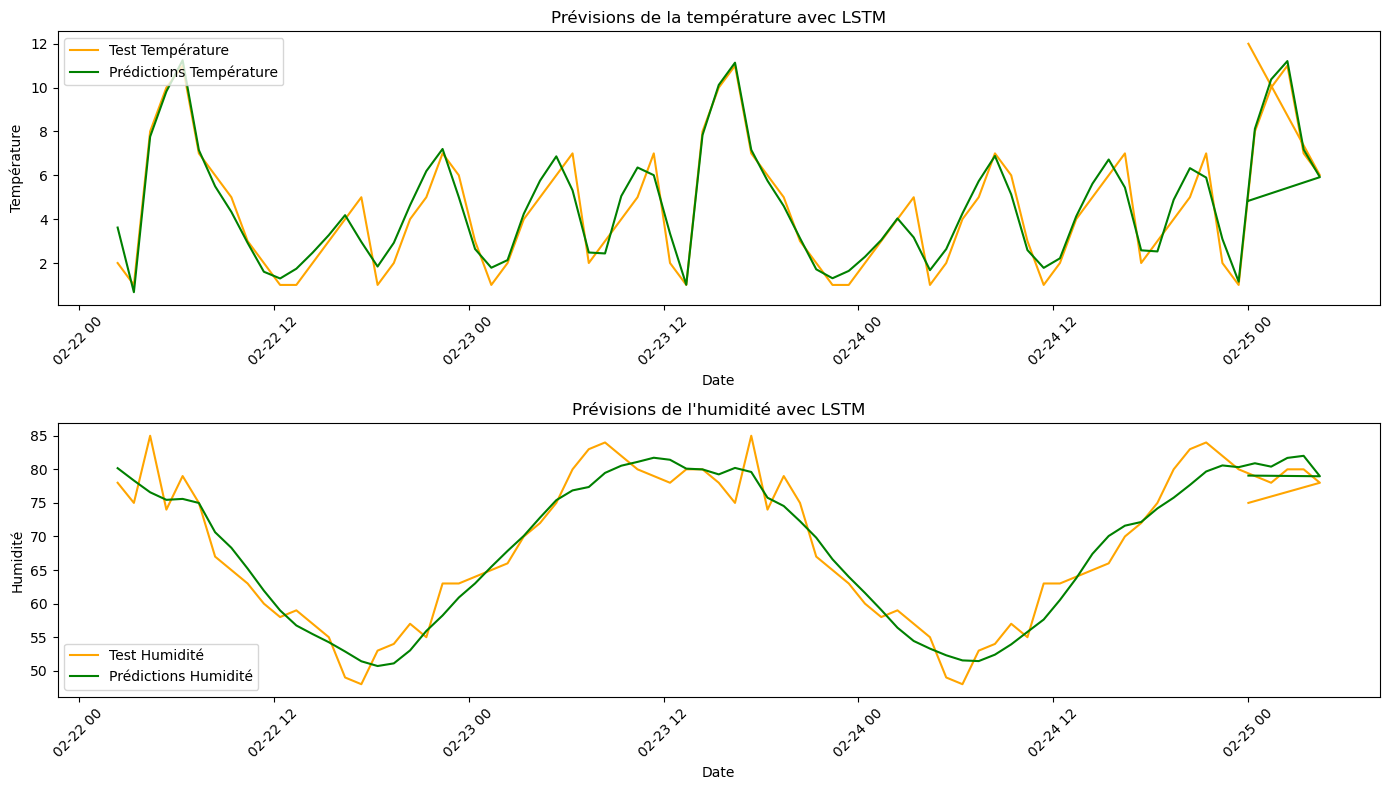

In [7]:
# Faire des prédictions
predictions = model.predict(X_test)

# Inverser la normalisation pour les prédictions
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculer les métriques de performance
mse_temp = mean_squared_error(y_test_actual[:, 0], predictions[:, 0])
mae_temp = mean_absolute_error(y_test_actual[:, 0], predictions[:, 0])
mse_hum = mean_squared_error(y_test_actual[:, 1], predictions[:, 1])
mae_hum = mean_absolute_error(y_test_actual[:, 1], predictions[:, 1])

print(f'Temperature - MSE: {mse_temp}, MAE: {mae_temp}')
print(f'Humidity - MSE: {mse_hum}, MAE: {mae_hum}')

# Tracer les prédictions et les vraies valeurs
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(df.index[train_size+seq_length:], y_test_actual[:, 0], label='Test Température', color='orange')
plt.plot(df.index[train_size+seq_length:], predictions[:, 0], label='Prédictions Température', color='green')
plt.title('Prévisions de la température avec LSTM')
plt.xlabel('Date')
plt.ylabel('Température')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
plt.plot(df.index[train_size+seq_length:], y_test_actual[:, 1], label='Test Humidité', color='orange')
plt.plot(df.index[train_size+seq_length:], predictions[:, 1], label='Prédictions Humidité', color='green')
plt.title('Prévisions de l\'humidité avec LSTM')
plt.xlabel('Date')
plt.ylabel('Humidité')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()